In [132]:
import numpy
import pandas
import sys
import os

sys.path.append("..")
sys.path.append('../utilities')
import pickling

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
new_output_file = '/gpfs/data/geraslab/Krzysztof/data/2010_2016_data/reports.pkl'

data_file = '/gpfs/data/geraslab/Nan/data/cancer_data_list_1204/data_0709_1453_120days_with_cancer_with_unknowns.pkl'

side_info_folder = '/gpfs/data/geraslab/Nan/data/side_info'

In [3]:
SIDE_INFOS = ['density', 'age', 'family_history', 'comparison']
def get_side_info(side_info_folder, info_type_list):
    info_file_dict = {'density': 'density_feature_by_index.pickle', 
                      'comparison': 'comparison_feature.pickle',
                      'age': 'age_feature.pickle',
                      'family_history': 'familyhistory_feature.pickle'}
    side_info = {}
    
    for info_type in info_type_list:
        side_info[info_type] = pickling.unpickle_from_file(os.path.join(side_info_folder, 
                                                                        info_file_dict[info_type]))
    return side_info

def get_exam_with_cancer_label(data_list):
    return [exam for exam in data_list if not exam['cancer_label']['unknown']]

def get_exam_without_cancer_label(data_list):
    return [exam for exam in data_list if exam['cancer_label']['unknown']]

def get_statistics_breakdown_by_biopsy(exams_without_biopsy, cancer_list):
    BIRADS_without_biopsy =  [exam['label'] for exam in exams_without_biopsy]
    BIRADS_with_biopsy =  [exam['label'] for exam in cancer_list]
    birads_without, counts_without = numpy.unique(numpy.array(BIRADS_without_biopsy), return_counts=True)
    birads_with, counts_with = numpy.unique(numpy.array(BIRADS_with_biopsy), return_counts=True)
    return pandas.DataFrame({'BIRADS':birads_with, 'Exams with Biopsy': counts_with, 'Exams without Biopsy': counts_without})


In [4]:
side_info = get_side_info(side_info_folder, SIDE_INFOS)

reports = pickling.unpickle_from_file(new_output_file)
data_list_training, data_list_validation, data_list_test,_ = pickling.unpickle_from_file(data_file)

data_list = data_list_training + data_list_validation + data_list_test

cancer_list = get_exam_with_cancer_label(data_list)
exams_without_biopsy = get_exam_without_cancer_label(data_list)

In [7]:
get_statistics_breakdown_by_biopsy(exams_without_biopsy, cancer_list).T

,0,1,2,3,4,5
BIRADS,0,1,2,3,4,5
Exams with Biopsy,4383,572,716,16,138,7
Exams without Biopsy,25122,104972,92487,873,128,12


In [560]:
def features_to_include(exam, reports):
    def map_age(age):
        if age<40:
            return 0
        else:
            return 1
#         elif age<50:
#             return 2
#         else:
#             return 3
    def name_without_noise(doctor_full_name):
        First_n = doctor_full_name.lower().split()[0]  
        Last_n = doctor_full_name.lower().split()[-1] 
        if Last_n =='c': Last_n = 'cathleen'
        return First_n + ' ' + Last_n
    try:
        key = (int(exam['patient_ID']), int(exam['accession_number']))
        doctor_full_name = reports[0][key]['raw_report']['SigningMd']
        raw_report = reports[0][key]['raw_report']['RawReport']
        
        if type(doctor_full_name) is str:
                
            features = {'SigningMd': doctor_full_name,
                        'F_L_name': name_without_noise(doctor_full_name),
                        
                        'BIRADS_label': exam['label'], 
                        'benign': exam['cancer_label']['benign'],
                        'malignant': exam['cancer_label']['malignant'],
                        
                        'age': side_info['age'][key],
                        'age_group': map_age(side_info['age'][key]),
                        #'density_pred': side_info['density'][key],
                        'density': numpy.argmax(side_info['density'][key]),
                        'with_family_history': 1*(sum(side_info['family_history'][key])>0),
                        'neg_family_history': side_info['family_history'][key][0],
                        'pos_family_history': side_info['family_history'][key][1],
                        'with_comparison': side_info['comparison'][key][1],
                        'without_comparison': side_info['comparison'][key][0],
                        'raw_report':raw_report
                       }
        else:
            features = None

        return features
    except AttributeError:
        print(doctor_full_name)
        
    except KeyError:
        pass
    
def build_data_frame_for_causal_study(cancer_list, reports):
    reports_with_cancer = [features_to_include(exam, reports) for exam in cancer_list ]
    reports_with_cancer = [feature for feature in reports_with_cancer if feature is not None]
    df = pandas.DataFrame(reports_with_cancer)
    df['index'] = df.index
    return df 

def docter_filter(df, DOCTOR_WITH_MIN_EXAMS = 30):
    exams_per_md = df.groupby(['F_L_name'])['index'].nunique()
    doctors_to_remove = exams_per_md[exams_per_md < DOCTOR_WITH_MIN_EXAMS].index
    desired_indices =  [i for i in df.index if df.F_L_name[i] not in doctors_to_remove]
    desired_df = df.iloc[desired_indices]
    return desired_df
def get_doctor_info(df):
    doctors = list(df['F_L_name'].unique())
    experience = [23, 11, 14, 29, 6, 
                  14, 18, 24, 12, 23,
                  24, 34, 23, 5, 10, 
                  19, 24, 42, 8, 16, 
                  29, 21, 8, 8, 3, 
                  30, 13, 9, 3, 37]
    experience_grouping = [2, 1, 1, 2, 0, 
                           1, 1, 2, 1, 2,
                           2, 3, 2, 0, 1,
                           1, 2, 3, 0, 1,
                           2, 2, 0, 0, 0,
                           3, 1, 0, 0, 3]
    sex = ['F', 'F', 'F', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 
           'F', 'F', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'F']

    docter_info_table = pandas.DataFrame({'F_L_name': doctors, 'sex_doctor': sex, 
                                          'experience_doctor': experience, 'experience_grouping': experience_grouping})
    df_with_doctor_info =  pandas.merge(df, docter_info_table, how='left', on='F_L_name', 
                                         left_index=False, right_index=False, sort=False,
                                         suffixes=('_x', '_y'), copy=True, indicator=False,
                                         validate=None)

    return df_with_doctor_info, docter_info_table

def binary_target_generation(df):
    df['malignant_pred_birads'] = [0 if x in [1,2,3] else 1 for x in df.BIRADS_label]  
    df['malignant_correction'] = (df['malignant_pred_birads'] == df['malignant'])*1
    
    df['benign_pred_birads'] = [1 if x in [2,3] else 0 for x in df.BIRADS_label]  
    df['benign_correction'] = (df['benign_pred_birads'] == df['benign'])*1
    
    return df 

In [561]:
df = build_data_frame_for_causal_study(cancer_list, reports)
df = docter_filter(df)
df_with_doctor_info, docter_info_table = get_doctor_info(df)

#df_with_doctor_info.to_csv('df.csv')

In [266]:
df_with_doctor_info.groupby(['BIRADS_label','malignant', 'benign'])['index'].count()#.loc[(df['F_L_name'] == 'patel kavita')].

BIRADS_label  malignant  benign
0             0          1         2400
              1          0          423
                         1          206
1             0          1          344
              1          0            7
                         1            3
2             0          1          384
              1          0           13
                         1           10
3             0          1           11
4             0          1           84
              1          0           11
                         1            4
5             1          0            5
                         1            1
Name: index, dtype: int64

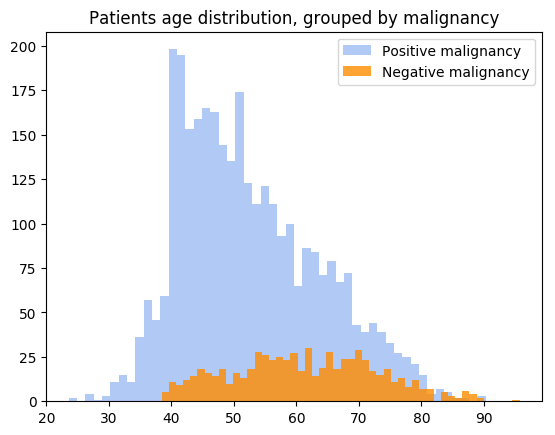

In [267]:
#data statistics 
#AGE INFO
plt.hist(df_with_doctor_info.loc[df_with_doctor_info.malignant ==0].age, bins = 50, alpha = 0.5, color = 'cornflowerblue',label = 'Positive malignancy')
plt.hist(df_with_doctor_info.loc[df_with_doctor_info.malignant ==1].age, bins = 50, alpha = 0.8, color = 'darkorange', label = 'Negative malignancy')
plt.legend(loc = 'best')
plt.title('Patients age distribution, grouped by malignancy')

In [268]:
df_with_doctor_info.groupby(['density'])['index'].count()

density
0     153
1    1390
2    2108
3     255
Name: index, dtype: int64

In [269]:
#Comparison
df_with_doctor_info.groupby(['with_comparison', 'without_comparison'])['index'].count()

with_comparison  without_comparison
0.0              0.0                    103
                 1.0                   1011
1.0              0.0                   2792
Name: index, dtype: int64

In [270]:
#Family history
df_with_doctor_info.groupby(['with_family_history', 'pos_family_history', 'neg_family_history'])['index'].count()

with_family_history  pos_family_history  neg_family_history
0                    0.0                 0.0                   3447
1                    0.0                 1.0                    145
                     1.0                 0.0                    314
Name: index, dtype: int64

In [271]:
docter_info_table.index = docter_info_table.F_L_name
table_count = df_with_doctor_info.loc[df_with_doctor_info.malignant == 0].groupby(['F_L_name'])[['index']].count()
docter_info_table['negative_malignant'] = table_count['index']
table_count = df_with_doctor_info.loc[df_with_doctor_info.malignant == 1].groupby(['F_L_name'])[['index']].count()
docter_info_table['positive_malignant'] = table_count['index']
docter_info_table = docter_info_table.sort_values(['experience_doctor'])

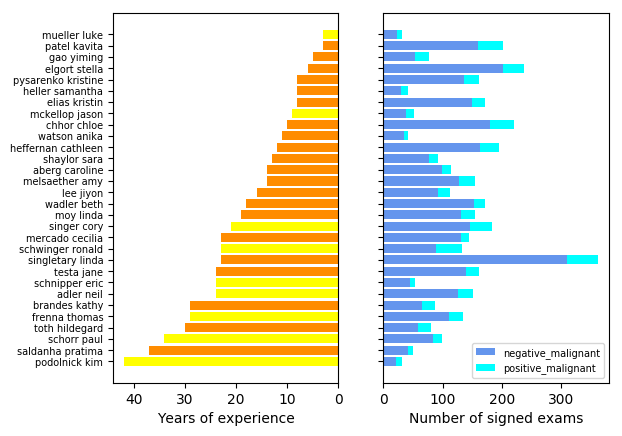

In [272]:
# DOCTOR INFO
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)


# Example data
people = docter_info_table.index
y_pos = np.arange(len(people))
ax = axs[0]
ax.barh(y_pos, docter_info_table['experience_doctor'],  align='center',
        color=['darkorange' if x == 'F' else 'yellow' for x in docter_info_table['sex_doctor'] ] )

ax.set_yticks(y_pos)
ax.set_yticklabels(people, fontsize=7)

ax.invert_yaxis()  # labels read top-to-bottom
ax.invert_xaxis()  # labels read top-to-bottom
ax.set_xlabel('Years of experience')

ax = axs[1]
ax.barh(y_pos, docter_info_table[ 'negative_malignant'],  align='center',
        color='cornflowerblue', label = 'negative_malignant')

ax.barh(y_pos, docter_info_table[ 'positive_malignant'],  align='center',
        color='aqua', left = docter_info_table[ 'negative_malignant'], label = 'positive_malignant')

ax.set_xlabel('Number of signed exams')
ax.legend(loc = 'best', fontsize=7)

plt.show()

In [ ]:
BIRADS_0 = df_with_doctor_info.loc[df_with_doctor_info.BIRADS_label == 0]
BIRADS_0['non_malignant'] = 1- BIRADS_0['malignant']

In [273]:
#Analysis BIRADS_NOT_0_CASES
BIRADS_NOT_0 = df_with_doctor_info.loc[df_with_doctor_info.BIRADS_label != 0]
BIRADS_NOT_0 = binary_target_generation(BIRADS_NOT_0)
BIRADS_NOT_0.groupby(['age_group'])['malignant_correction'].agg(['count','mean'])
BIRADS_NOT_0.groupby(['sex_doctor', 'experience_grouping'])['malignant_correction'].agg(['count','mean'])
BIRADS_NOT_0.groupby(['experience_doctor'])['malignant_correction'].mean()
BIRADS_NOT_0.groupby(['sex_doctor'])['malignant_correction'].mean()

/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

sex_doctor
F    0.847953
M    0.932642
Name: malignant_correction, dtype: float64

In [274]:
def false_positive(row):
    if (row.malignant_pred_birads == 1)  and row.malignant == 0 :
        return 1
    else:
        return 0
def false_negative(row):
    if (row.malignant_pred_birads == 0)  and row.malignant == 1 :
        return 1
    else:
        return 0

In [275]:
BIRADS_NOT_0.loc[:, 'false_positive'] = BIRADS_NOT_0.apply(false_positive, axis = 1)
BIRADS_NOT_0.loc[:, 'false_negative'] = BIRADS_NOT_0.apply(false_negative, axis = 1)

/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [553]:
BIRADS_NOT_0.to_csv('BIRADS_NOT_0.csv')
BIRADS_0.to_csv('BIRADS_0.csv')

In [550]:
tb_mid = BIRADS_NOT_0.groupby(['with_family_history', 'F_L_name'])[['malignant_correction', 
                                                            'false_positive', 'false_negative']].mean()
tb_mid = tb_mid.fillna(0)
tb_mid['F_L_name'] = [name for (bi, name) in tb_mid.index]
tb_mid['with_family_history'] = [bi for (bi, name) in tb_mid.index]

tb_with = pandas.merge(tb_mid.loc[tb_mid.with_family_history == 1], docter_info_table, how='right', on='F_L_name', 
                                         left_index=False, right_index=False, sort=False,
                                         suffixes=('_x', '_y'), copy=True, indicator=False,
                                         validate=None)
tb_with = tb_with.sort_values(['experience_doctor']).fillna(0)

tb_without = pandas.merge(tb_mid.loc[tb_mid.with_family_history == 0], docter_info_table, how='right', on='F_L_name', 
                                         left_index=False, right_index=False, sort=False,
                                         suffixes=('_x', '_y'), copy=True, indicator=False,
                                         validate=None)

tb_without = tb_without.sort_values(['experience_doctor']).fillna(0)

/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: 'F_L_name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [551]:
tb_mid = BIRADS_0.groupby(['with_family_history', 'F_L_name'])[['non_malignant']].mean()
tb_mid = tb_mid.fillna(0)
tb_mid['F_L_name'] = [name for (bi, name) in tb_mid.index]
tb_mid['with_family_history'] = [bi for (bi, name) in tb_mid.index]

tb_with_0 = pandas.merge(tb_mid.loc[tb_mid.with_family_history == 1], docter_info_table, how='right', on='F_L_name', 
                                         left_index=False, right_index=False, sort=False,
                                         suffixes=('_x', '_y'), copy=True, indicator=False,
                                         validate=None)
tb_with_0 = tb_with_0.sort_values(['experience_doctor']).fillna(0)

tb_without_0 = pandas.merge(tb_mid.loc[tb_mid.with_family_history == 0], docter_info_table, how='right', on='F_L_name', 
                                         left_index=False, right_index=False, sort=False,
                                         suffixes=('_x', '_y'), copy=True, indicator=False,
                                         validate=None)

tb_without_0 = tb_without_0.sort_values(['experience_doctor']).fillna(0)

/home/kjg5/breast_cancer_mc/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: 'F_L_name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


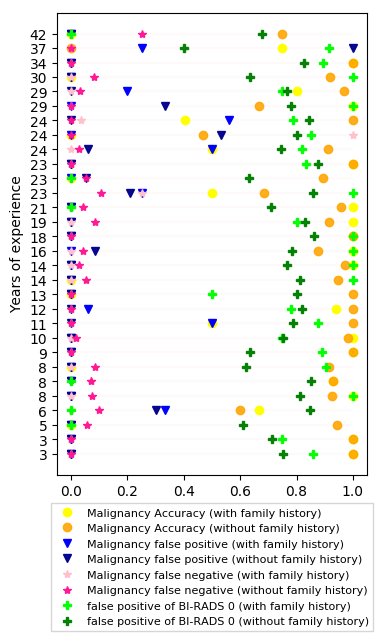

In [552]:
plt.figure(figsize = (4, 6))
x= list(range(len(tb_with['malignant_correction'])))
#malignant_correction_ = list(tb.loc[tb.with_family_history==1]['malignant_correction'])

labels = ['%d'%(y)  for (x, y) in zip(list(tb_with['F_L_name']) , list(tb_with['experience_doctor']))] 

plt.plot( list(tb_with['malignant_correction']), x,
         'o', color = 'yellow', label = 'Malignancy Accuracy (with family history)')
plt.plot(list(tb_without['malignant_correction']), x, 
         'o', color = 'orange', label = 'Malignancy Accuracy (without family history)', alpha = 30)



plt.plot(list(tb_with['false_positive']), x, 
         'v', color = 'blue', label = 'Malignancy false positive (with family history)')
plt.plot( list(tb_without['false_positive']), x,
         'v', color = 'darkblue', label = 'Malignancy false positive (without family history)', alpha = 10)



plt.plot( list(tb_with['false_negative']), x,
         '*', color = 'pink', label = 'Malignancy false negative (with family history)')
plt.plot( list(tb_without['false_negative']), x,
         '*', color = 'deeppink', label = 'Malignancy false negative (without family history)', alpha = 10)


plt.plot(list(tb_with_0['non_malignant']), x, 
         'P', color = 'lime', label = 'false positive of BI-RADS 0 (with family history)', alpha = 10)

plt.plot(list(tb_without_0['non_malignant']), x, 
         'P', color = 'green', label = 'false positive of BI-RADS 0 (without family history)', alpha = 10)

plt.hlines(x, xmin = 0, xmax = 1, colors = 'snow')

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.yticks(x, labels)

plt.ylabel('Years of experience')
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=False, fontsize = 8)

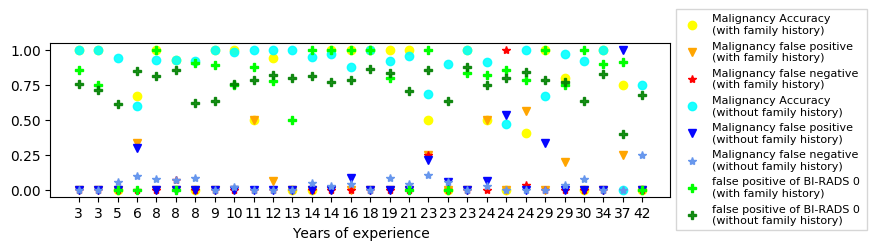

In [522]:
plt.figure(figsize = (8, 2))
x= list(range(len(tb_with['malignant_correction'])))
#malignant_correction_ = list(tb.loc[tb.with_family_history==1]['malignant_correction'])

labels = ['%d'%(y)  for (x, y) in zip(list(tb_with['F_L_name']) , list(tb_with['experience_doctor']))] 

plt.plot(x, list(tb_with['malignant_correction']), 
         'o', color = 'yellow', label = 'Malignancy Accuracy \n(with family history)')
plt.plot(x, list(tb_with['false_positive']), 
         'v', color = 'orange', label = 'Malignancy false positive \n(with family history)')
plt.plot(x, list(tb_with['false_negative']), 
         '*', color = 'red', label = 'Malignancy false negative \n(with family history)')

plt.plot(x, list(tb_without['malignant_correction']), 
         'o', color = 'aqua', label = 'Malignancy Accuracy \n(without family history)', alpha = 30)
plt.plot(x, list(tb_without['false_positive']), 
         'v', color = 'blue', label = 'Malignancy false positive \n(without family history)', alpha = 10)
plt.plot(x, list(tb_without['false_negative']), 
         '*', color = 'cornflowerblue', label = 'Malignancy false negative \n(without family history)', alpha = 10)

plt.plot(x, list(tb_with_0['non_malignant']), 
         'P', color = 'lime', label = 'false positive of BI-RADS 0 \n(with family history)')

plt.plot(x, list(tb_without_0['non_malignant']), 
         'P', color = 'green', label = 'false positive of BI-RADS 0 \n(without family history)', alpha = 30)



# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels)

plt.xlabel('Years of experience')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=False, fontsize = 8)

In [443]:
tb.groupby(['with_family_history', 'experience_grouping'])[['malignant_correction', 
                                                            'false_positive', 'false_negative']].mean()

malignant_correction  false_positive  \
with_family_history experience_grouping                                         
0                   0                                0.914335        0.037500   
                    1                                0.966268        0.009259   
                    2                                0.839044        0.131841   
                    3                                0.667500        0.250000   
1                   0                                0.932540        0.055556   
                    1                                0.920168        0.079832   
                    2                                0.650439        0.188925   
                    3                                0.875000        0.125000   

                                         false_negative  
with_family_history experience_grouping                  
0                   0                          0.048165  
                    1                          0.024473  
                    2                          0.029115  
                    3                          0.082500  
1                   0                          0.011905  
                    1                          0.000000  
                    2                          0.160636  
                    3                          0.000000

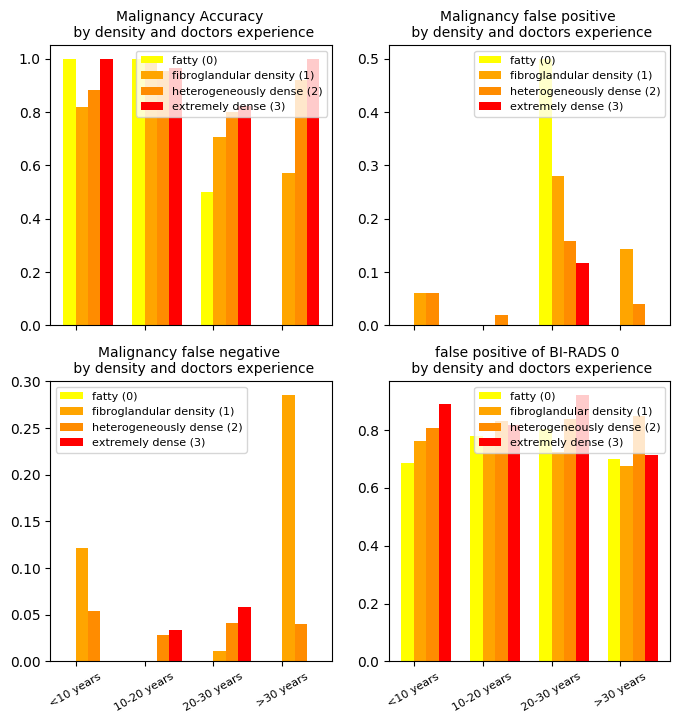

In [408]:
tb = BIRADS_NOT_0.groupby(['density', 'experience_grouping'])[['malignant_correction', 
                                                            'false_positive', 'false_negative']].agg(['mean','std']) 

import numpy as np
import matplotlib.pyplot as plt

def plot_bars(Means, Std, title, ax, with_tick = True):
    N = 4

    #fig, ax = plt.subplots()

    ind = np.arange(N)    # the x locations for the groups
    width = 0.18         # the width of the bars
    p1 = ax.bar(ind,           Means[0], width, color='yellow',     bottom=0, )#    yerr=Std[0])
    p2 = ax.bar(ind + width,   Means[1], width, color='orange', bottom=0,   )#  yerr=Std[1])
    p3 = ax.bar(ind + width*2, Means[2], width, color='darkorange',       bottom=0,)#     yerr=Std[2])
    
    p4 = ax.bar(ind + width*3, Means[3], width, color='red', bottom=0)

    ax.set_title(title, fontsize = 10)
    ax.set_xticks(ind + width / 2)
    if with_tick:
        ax.set_xticklabels(('<10 years', '10-20 years', '20-30 years', '>30 years'), fontsize = 8,  rotation = 30)
    else:
        ax.set_xticklabels(('', '', '', ''), fontsize = 10,  rotation = 30)
    ax.legend((p1[0], p2[0], p3[0], p4[0]), 
              ('fatty (0)', 'fibroglandular density (1)',  'heterogeneously dense (2)', 'extremely dense (3)'), 
              fontsize = 8)
    ax.autoscale_view()

    #plt.show()
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (8, 8))

Means = [list(tb['malignant_correction']['mean'].loc[0]) + [0]] + [list(tb['malignant_correction']['mean'].loc[i]) for i in [1,2,3] ]
Std = [list(tb['malignant_correction']['std'].loc[0]) + [0]] + [list(tb['malignant_correction']['std'].loc[i])  for i in [1,2,3] ]

title = 'Malignancy Accuracy \n by density and doctors experience'
plot_bars(Means, Std, title, axs[0, 0], False)


Means = [list(tb['false_positive']['mean'].loc[0]) + [0]] + [list(tb['false_positive']['mean'].loc[i])  for i in [1,2,3] ]
Std = [list(tb['false_positive']['std'].loc[0]) + [0]] + [list(tb['false_positive']['std'].loc[i])  for i in [1,2,3] ]


title = 'Malignancy false positive \n by density and doctors experience'
plot_bars(Means, Std, title, axs[0, 1], False)

Means = [list(tb['false_negative']['mean'].loc[0]) + [0]] + [list(tb['false_negative']['mean'].loc[i])  for i in [1,2,3] ]
Std = [list(tb['false_negative']['std'].loc[0]) + [0]] + [list(tb['false_negative']['std'].loc[i])  for i in [1,2,3] ]

title = 'Malignancy false negative \n by density and doctors experience'
plot_bars(Means, Std, title, axs[1, 0])

tb = BIRADS_0.groupby(['density', 'experience_grouping'])['non_malignant'].agg(['mean', 'std', 'count', 'sum'])

Means = [list(tb['mean'].loc[i])  for i in [0,1,2,3] ]
Std = [list(tb['std'].loc[i])  for i in [0,1,2,3] ]

title = 'false positive of BI-RADS 0 \n by density and doctors experience'
plot_bars(Means, Std, title, axs[1, 1])
plt.show()

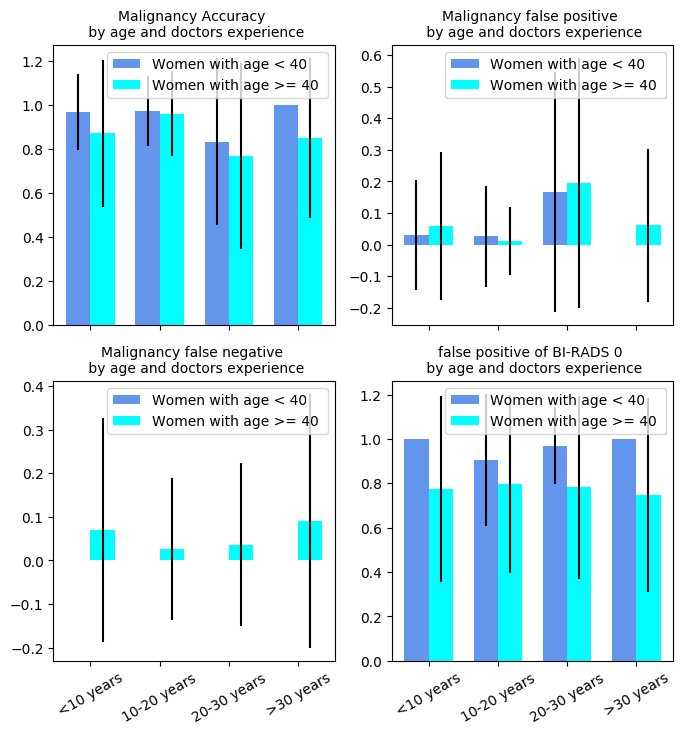

In [395]:
import numpy as np
import matplotlib.pyplot as plt
tb = BIRADS_NOT_0.groupby(['age_group', 'experience_grouping'])[['malignant_correction', 
                                                            'false_positive', 'false_negative']].agg(['mean','std']) 

def plot_bars(youngMeans, youngStd, oldMeans, oldStd, title, ax, with_tick = True):
    N = 4

    #fig, ax = plt.subplots()

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, youngMeans, width, color='cornflowerblue', bottom=0, yerr=youngStd)

    p2 = ax.bar(ind + width, oldMeans, width,
                color='aqua', bottom=0, yerr=oldStd)

    ax.set_title(title, fontsize = 10)
    ax.set_xticks(ind + width / 2)
    if with_tick:
        ax.set_xticklabels(('<10 years', '10-20 years', '20-30 years', '>30 years'), fontsize = 10,  rotation = 30)
    else:
        ax.set_xticklabels(('', '', '', ''), fontsize = 10,  rotation = 30)
    ax.legend((p1[0], p2[0]), ('Women with age < 40 ', 'Women with age >= 40 '), fontsize = 10)
    ax.autoscale_view()

    #plt.show()
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (8, 8))

youngMeans = list(tb['malignant_correction']['mean'].loc[0])
youngStd = list(tb['malignant_correction']['std'].loc[0])

oldMeans = list(tb['malignant_correction']['mean'].loc[1])
oldStd = list(tb['malignant_correction']['std'].loc[1])

title = 'Malignancy Accuracy \n by age and doctors experience'
plot_bars(youngMeans, youngStd, oldMeans, oldStd, title, axs[0, 0], False)

youngMeans = list(tb['false_positive']['mean'].loc[0])
youngStd = list(tb['false_positive']['std'].loc[0])

oldMeans = list(tb['false_positive']['mean'].loc[1])
oldStd = list(tb['false_positive']['std'].loc[1])

title = 'Malignancy false positive \n by age and doctors experience'
plot_bars(youngMeans, youngStd, oldMeans, oldStd, title, axs[0, 1],  False)

youngMeans = list(tb['false_negative']['mean'].loc[0])
youngStd = list(tb['false_negative']['std'].loc[0])

oldMeans = list(tb['false_negative']['mean'].loc[1])
oldStd = list(tb['false_negative']['std'].loc[1])

title = 'Malignancy false negative \n by age and doctors experience'
plot_bars(youngMeans, youngStd, oldMeans, oldStd, title, axs[1, 0])

tb = BIRADS_0.groupby(['age_group', 'experience_grouping'])['non_malignant'].agg(['mean', 'std', 'count', 'sum'])

youngMeans = list(tb['mean'].loc[0])
youngStd = list(tb['std'].loc[0])

oldMeans = list(tb['mean'].loc[1])
oldStd = list(tb['std'].loc[1])

title = 'false positive of BI-RADS 0 \n by age and doctors experience'
plot_bars(youngMeans, youngStd, oldMeans, oldStd, title, axs[1, 1])

plt.show()

In [286]:
young_doctor_df = BIRADS_NOT_0.loc[BIRADS_NOT_0.age_group == 0].groupby(['F_L_name'])[['malignant_correction', 'false_positive', 'false_negative']].mean()
old_doctor_df = BIRADS_NOT_0.loc[BIRADS_NOT_0.age_group == 1].groupby(['F_L_name'])[['malignant_correction', 'false_positive', 'false_negative']].mean()
both_yound_old = set(old_doctor_df.index) and set(young_doctor_df.index)
young_doctor_df = young_doctor_df.loc[both_yound_old]
old_doctor_df = old_doctor_df.loc[both_yound_old]

In [311]:
table_all = young_doctor_df.copy()
table_all['malignant_correction_young'] = young_doctor_df['malignant_correction']
table_all['false_positive_young'] = young_doctor_df['false_positive']
table_all['false_negative_young'] = young_doctor_df['false_negative']
table_all['malignant_correction_old'] = old_doctor_df['malignant_correction']
table_all['false_positive_old'] = old_doctor_df['false_positive']
table_all['false_negative_old'] = old_doctor_df['false_negative']

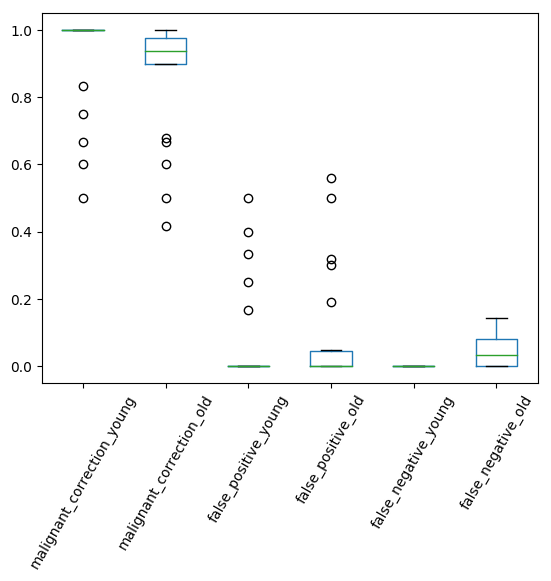

In [318]:
table_all[['malignant_correction_young', 'malignant_correction_old', 
                'false_positive_young','false_positive_old',
                'false_negative_young','false_negative_old',
        ]].plot.box(rot = 60)
#young_doctor_df.plot.box()

In [301]:
from scipy import stats
print(stats.ttest_ind(old_doctor_df['malignant_correction'],young_doctor_df['malignant_correction'], equal_var = False))
print(stats.ttest_ind(old_doctor_df['false_positive'],young_doctor_df['false_positive'], equal_var = False))
print(stats.ttest_ind(old_doctor_df['false_negative'],young_doctor_df['false_negative'], equal_var = False))


Ttest_indResult(statistic=-1.2260601830972826, pvalue=0.2268095164038875)
Ttest_indResult(statistic=0.2840281753370435, pvalue=0.7777406435114939)
Ttest_indResult(statistic=4.870048423266756, pvalue=7.220207864956884e-05)


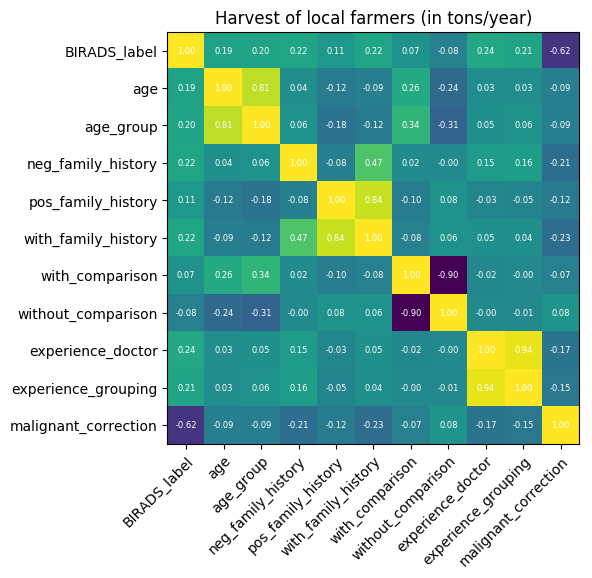

In [243]:
fig, ax = plt.subplots(figsize = (6, 6))
corr_map = BIRADS_NOT_0[['BIRADS_label', 'age', 'age_group', 
              'neg_family_history', 'pos_family_history', 'with_family_history',
              'with_comparison', 'without_comparison',
              'experience_doctor', 'experience_grouping','malignant_correction',
             ]].corr()

im = ax.imshow(corr_map)


xticks = ['BIRADS_label', 'age', 'age_group', 
              'neg_family_history', 'pos_family_history', 'with_family_history',
              'with_comparison', 'without_comparison',
              'experience_doctor', 'experience_grouping', 
              'malignant_correction']

yticks = ['BIRADS_label', 'age', 'age_group', 
              'neg_family_history', 'pos_family_history', 'with_family_history',
              'with_comparison', 'without_comparison',
              'experience_doctor', 'experience_grouping', 
              'malignant_correction']


# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(yticks)):
    for j in range(len(xticks)):
        text = ax.text(j, i, '%1.2f'%corr_map[yticks[i]][xticks[j]],
                       ha="center", va="center", color="w", fontsize = 6)

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()
